In [21]:
import pandas as pd
import glob
import os

# Define the directory containing the CSV files
data_dir = "/Users/andrewcrow/Desktop/Desktop/Phoenix_Foot_Peel/Order_Reports/USA_Canada/"

# Get a list of all CSV files (ignoring directories)
csv_files = [f for f in glob.glob(os.path.join(data_dir, "*.csv")) if os.path.isfile(f)]

# Check if files are found
if not csv_files:
    print("No CSV files found in the directory!")
else:
    # Read all CSVs into a list of DataFrames
    df_list = [pd.read_csv(f) for f in csv_files]

    # Concatenate all DataFrames, filling missing columns with NaN
    products_df = pd.concat(df_list, ignore_index=True, sort=False)

    print("Combined DataFrame shape:", products_df.shape)

Combined DataFrame shape: (34956, 80)


In [22]:
# Step 1: Find the common columns across all DataFrames
common_columns = df_list[0].columns  # Start with the columns from the first DataFrame
for df in df_list[1:]:
    common_columns = common_columns.intersection(df.columns)  # Keep only columns that are in every DataFrame

# Convert the common columns to a list to ensure order
common_columns = list(common_columns)

# Step 2: Filter each DataFrame to keep only the common columns
df_list = [df[common_columns] for df in df_list]

# Step 3: Concatenate DataFrames and reset index
products_df = pd.concat(df_list, ignore_index=True)

# Step 4: Reorder columns based on the first DataFrame's original column order
# This ensures that the final DataFrame columns are ordered as they were in the first DataFrame
products_df = products_df[common_columns]

In [23]:
data_dict = pd.DataFrame({
    "Column Name": products_df.columns,
    "Data Type": products_df.dtypes.values,
    "Unique Values": products_df.nunique().values,
    "Missing Values": products_df.isnull().sum().values,
    "Sample Value": products_df.iloc[0].values
})
print(data_dict)

                         Column Name Data Type  Unique Values  Missing Values  \
0                    amazon-order-id    object          33192               0   
1                  merchant-order-id    object          33188               0   
2                      purchase-date    object          33098               0   
3                  last-updated-date    object          33159               0   
4                       order-status    object              3               0   
5                fulfillment-channel    object              1               0   
6                      sales-channel    object              5               0   
7                      order-channel   float64              0           34956   
8                                url    object              5           33086   
9                 ship-service-level    object              5               0   
10                      product-name    object             43               0   
11                          

In [24]:
products_df["purchase-date"] = pd.to_datetime(products_df["purchase-date"]).dt.date

In [25]:
print("Earliest purchase date:", products_df["purchase-date"].min())
print("Latest purchase date:", products_df["purchase-date"].max())

Earliest purchase date: 2022-01-01
Latest purchase date: 2025-01-01


In [26]:
products_df["sku"].unique()

array(['PhoenixGelSocks', 'PhoenixUnscented', 'FrostCA', 'CanadaHeat',
       '3packunscentedCA', 'USHeat', 'LR-ZY93-1V7I', 'FootRepairCream',
       'U4-LWZC-FBXH', 'VG-R9N4-CV7R', 'RQ-UTJB-E9J3', '3packunscented',
       'IV-X6H0-W8T1', '4packunscented', 'Unscented4packCA',
       'J8-MMS9-IP22', 'UNKNOW'], dtype=object)

In [27]:
sku_map = {
    "PhoenixGelSocks": "GelSocks",
    "PhoenixUnscented": "Unscented2",
    "U4-LWZC-FBXH": "Unscented2",
    "J8-MMS9-IP22": "Unscented2",
    "RQ-UTJB-E9J3": "Unscented3",
    "3packunscented": "Unscented3",
    "3packunscentedCA": "Unscented3",
    "VG-R9N4-CV7R": "Unscented4",
    "4packunscented": "Unscented4",
    "Unscented4packCA": "Unscented4",
    "LR-ZY93-1V7I": "Frost2",
    "FrostCA": "Frost2",
    "USHeat": "Heat2",
    "CanadaHeat": "Heat2",
    "FootRepairCream": "FootCream"
}

# Create a copy of the DataFrame to avoid modifying the original
products_df = products_df.copy()

# Apply the mapping and fill NaN values with the original 'sku' value
products_df["sku"] = products_df["sku"].map(sku_map).fillna(products_df["sku"])

In [28]:
products_df["sku"].unique()

array(['GelSocks', 'Unscented2', 'Frost2', 'Heat2', 'Unscented3',
       'FootCream', 'Unscented4', 'IV-X6H0-W8T1', 'UNKNOW'], dtype=object)

In [29]:
products_df = products_df.dropna(subset=['item-price'])

In [30]:
print(products_df.shape)

(32477, 40)


In [31]:
products_df["sku"].unique()

array(['GelSocks', 'Unscented2', 'Frost2', 'Heat2', 'Unscented3',
       'FootCream', 'Unscented4'], dtype=object)

In [32]:
skus = ['Frost2', 'GelSocks', 'Heat2', 'Unscented2', 'Unscented3', 'FootCream', 'Unscented4']
sku_price_counts = {}

for sku in skus:
    df = products_df[(products_df["sku"] == sku) & (products_df["currency"] == "USD")].copy()
    
    # Compute per-unit price and round to 2 decimals
    df["unit-price"] = (df["item-price"] / df["quantity"]).round(2)
    
    # Remove rows where unit-price is 0.00
    df = df[df["unit-price"] > 0]
    
    # Count occurrences of each unit price
    price_counts = df["unit-price"].value_counts().reset_index()
    price_counts.columns = ["unit-price", "count"]
    
    # Store in dictionary
    sku_price_counts[sku] = price_counts

# Print results for each SKU
for sku, df in sku_price_counts.items():
    print(f"\nUnit Price Counts for {sku}:\n", df)



Unit Price Counts for Frost2:
     unit-price  count
0        23.95   3686
1        22.95   1529
2        19.95    367
3        21.95    339
4        19.85     89
5        16.76     87
6        17.96     59
7        19.16     56
8        19.50     52
9        22.00     26
10       18.95     17
11       18.36     17
12       17.95      7
13       19.80      1

Unit Price Counts for GelSocks:
    unit-price  count
0       22.85   3268
1       23.85   1452
2       21.50    662
3       24.95    214
4       19.95    106
5       18.28     70
6       17.20     61
7       17.14     55

Unit Price Counts for Heat2:
     unit-price  count
0        23.95    617
1        22.95    509
2        19.95    165
3        21.95    105
4        19.50     28
5        19.85     23
6        16.76     17
7        14.95     15
8        15.88     10
9        21.00      8
10       17.96      7
11       17.95      5
12       18.95      5
13       16.06      5

Unit Price Counts for Unscented2:
     unit-price  co

In [53]:
import pandas as pd

# Filter for USD transactions
df_filtered = products_df[products_df["currency"] == "USD"].copy()

# Compute per-unit price and round to 2 decimals
df_filtered["unit-price"] = (df_filtered["item-price"] / df_filtered["quantity"]).round(2)

# Remove rows where unit-price is 0
df_filtered = df_filtered[df_filtered["unit-price"] > 0]

# Convert purchase-date to datetime (if not already)
df_filtered["purchase-date"] = pd.to_datetime(df_filtered["purchase-date"], errors="coerce")

# Filter rows so that only data between 2022-01-01 and 2024-12-31 is kept
df_filtered = df_filtered[
    (df_filtered["purchase-date"] >= "2022-01-01") & 
    (df_filtered["purchase-date"] <= "2024-12-31")
]

# Print the total number of rows after all filtering
print("Total number of rows after filtering:", df_filtered.shape[0])


Total number of rows after filtering: 29576


/var/folders/x8/4y413tdj277g3r1kq1drgc300000gn/T/ipykernel_19532/734344225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["unit-price"], y=df["count"], palette="viridis")


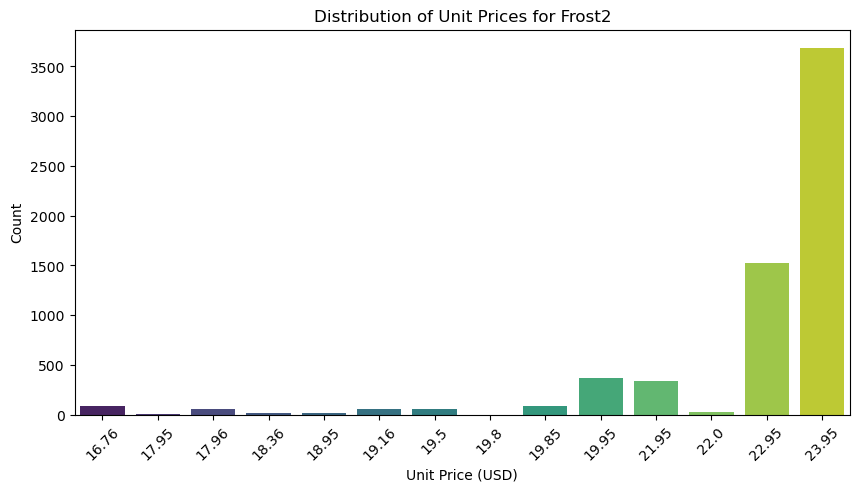

/var/folders/x8/4y413tdj277g3r1kq1drgc300000gn/T/ipykernel_19532/734344225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["unit-price"], y=df["count"], palette="viridis")


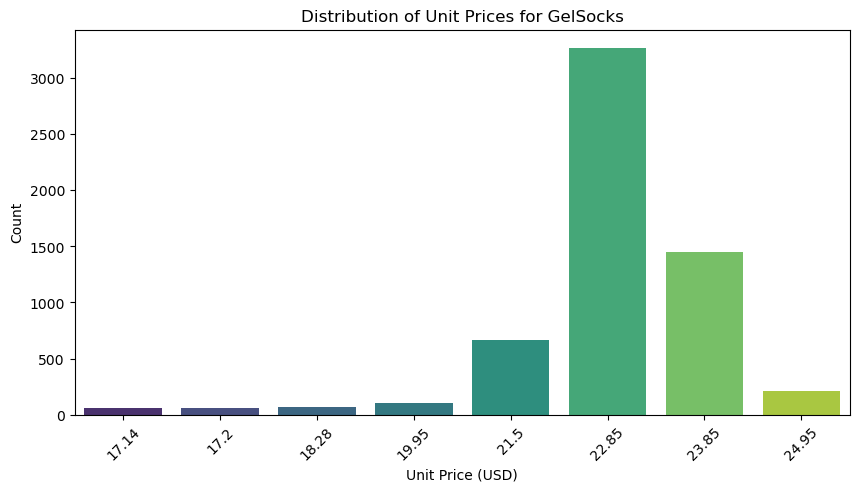

/var/folders/x8/4y413tdj277g3r1kq1drgc300000gn/T/ipykernel_19532/734344225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["unit-price"], y=df["count"], palette="viridis")


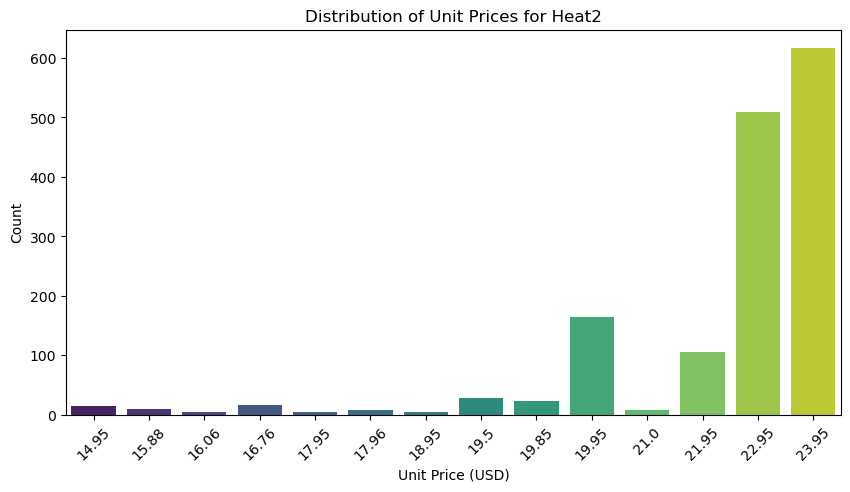

/var/folders/x8/4y413tdj277g3r1kq1drgc300000gn/T/ipykernel_19532/734344225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["unit-price"], y=df["count"], palette="viridis")


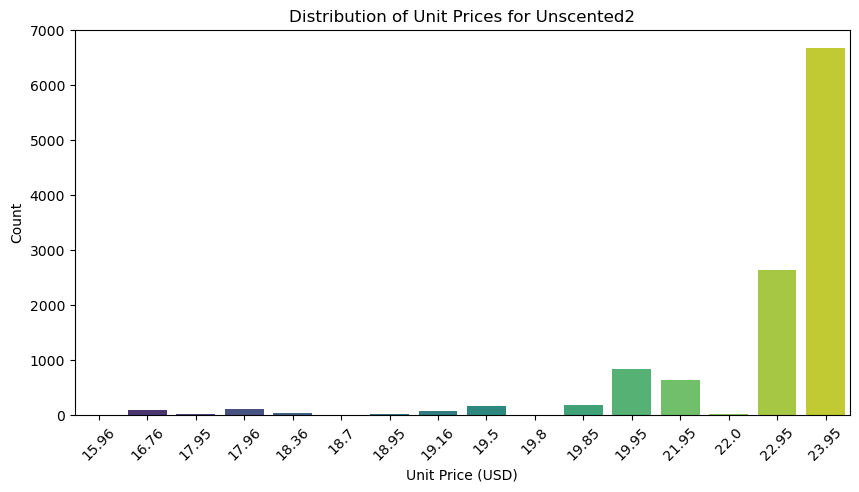

/var/folders/x8/4y413tdj277g3r1kq1drgc300000gn/T/ipykernel_19532/734344225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["unit-price"], y=df["count"], palette="viridis")


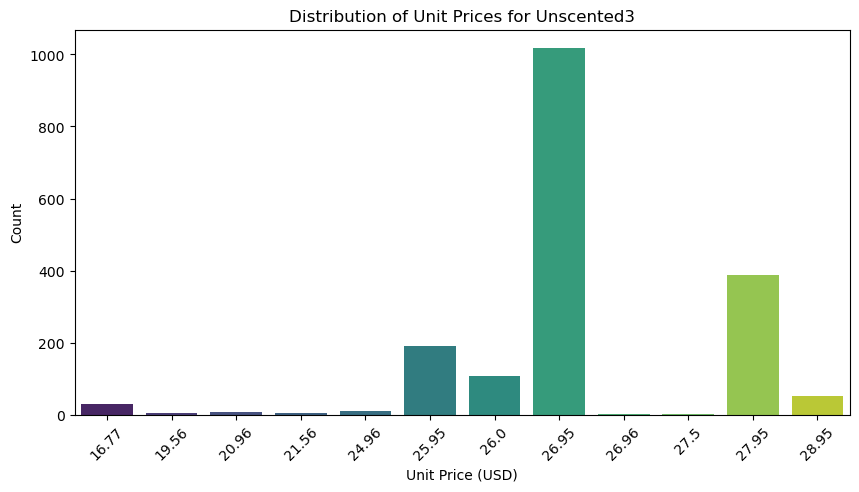

/var/folders/x8/4y413tdj277g3r1kq1drgc300000gn/T/ipykernel_19532/734344225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["unit-price"], y=df["count"], palette="viridis")


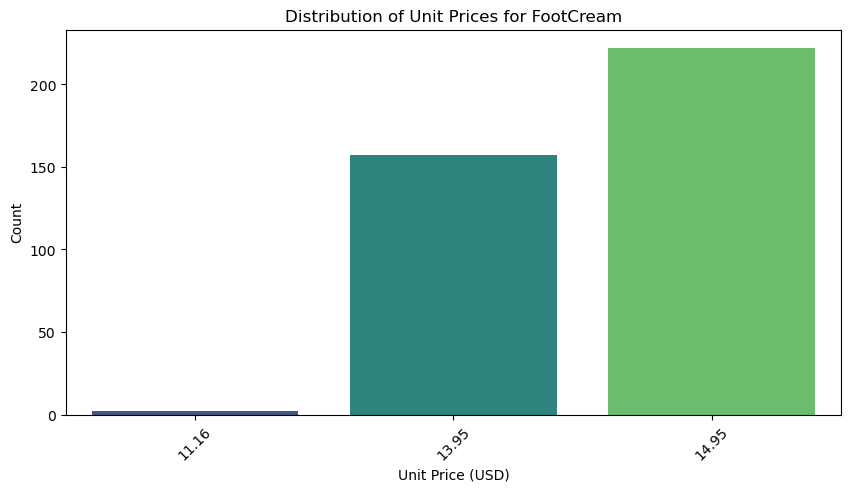

/var/folders/x8/4y413tdj277g3r1kq1drgc300000gn/T/ipykernel_19532/734344225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["unit-price"], y=df["count"], palette="viridis")


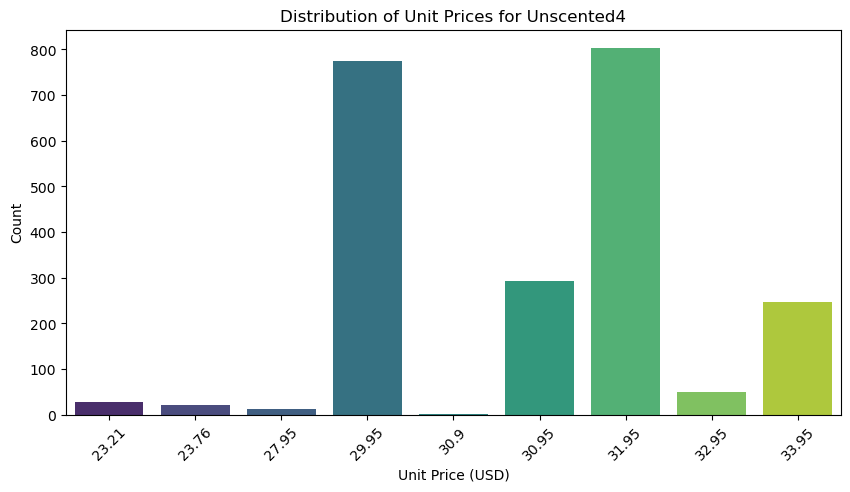

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through each SKU and create a separate bar chart
for sku, df in sku_price_counts.items():
    plt.figure(figsize=(10, 5))  # Set figure size for each SKU
    sns.barplot(x=df["unit-price"], y=df["count"], palette="viridis")

    # Titles and labels
    plt.xlabel("Unit Price (USD)")
    plt.ylabel("Count")
    plt.title(f"Distribution of Unit Prices for {sku}")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the chart
    plt.show()

In [35]:
# Filter for USD transactions and remove FootCream
ts_df = products_df[(products_df["currency"] == "USD") & (products_df["sku"] != "FootCream") & (products_df["sku"] != "GelSocks")].copy()

# Compute per-unit price and remove zero-priced rows
ts_df["unit-price"] = (ts_df["item-price"] / ts_df["quantity"]).round(2)
ts_df = ts_df[ts_df["unit-price"] > 0]

# Convert purchase-date to datetime and extract year-month
ts_df["purchase-date"] = pd.to_datetime(ts_df["purchase-date"], errors="coerce")
ts_df["year_month"] = ts_df["purchase-date"].dt.to_period("M")
ts_df = ts_df[ts_df["year_month"] < "2025-01-01"].copy()

# Aggregate monthly data by SKU and unit-price
final_monthly_df = (
    ts_df.groupby(["year_month", "sku", "unit-price"]).agg(
        quantity_sold=("quantity", "sum"),
        total_revenue=("item-price", "sum")
    ).reset_index()
)

print("Monthly aggregated DataFrame shape:", final_monthly_df.shape)
print(final_monthly_df.head())

Monthly aggregated DataFrame shape: (293, 5)
  year_month         sku  unit-price  quantity_sold  total_revenue
0    2022-01      Frost2       23.95             59        1413.05
1    2022-01  Unscented2       23.95            797       19088.15
2    2022-02      Frost2       23.95            169        4047.55
3    2022-02  Unscented2       23.95            541       12956.95
4    2022-03      Frost2       23.95             87        2083.65


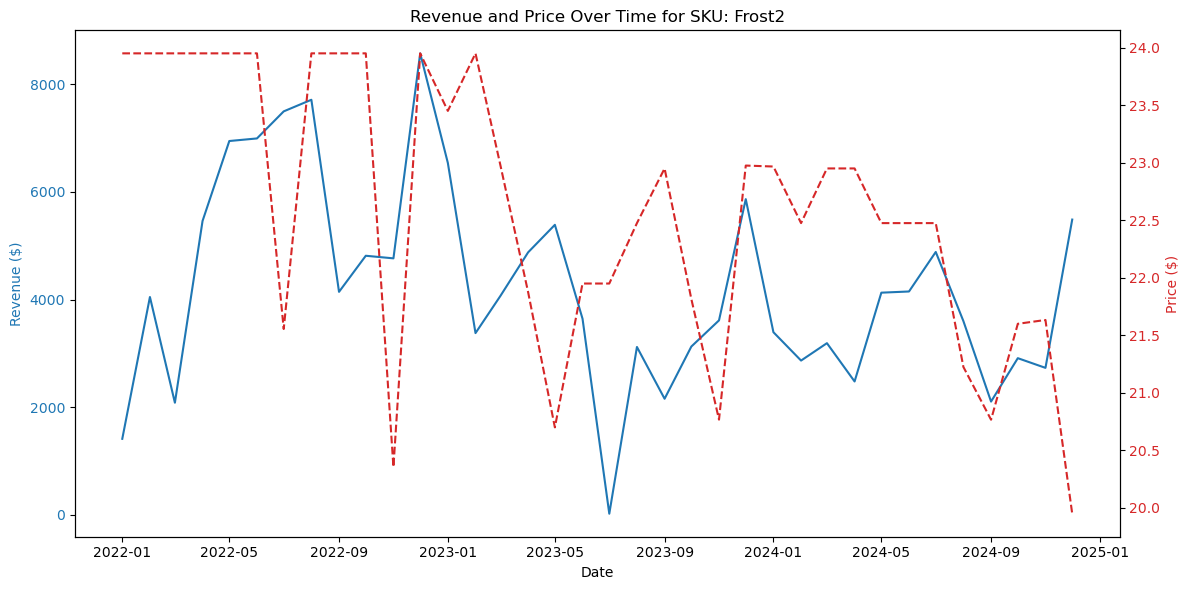

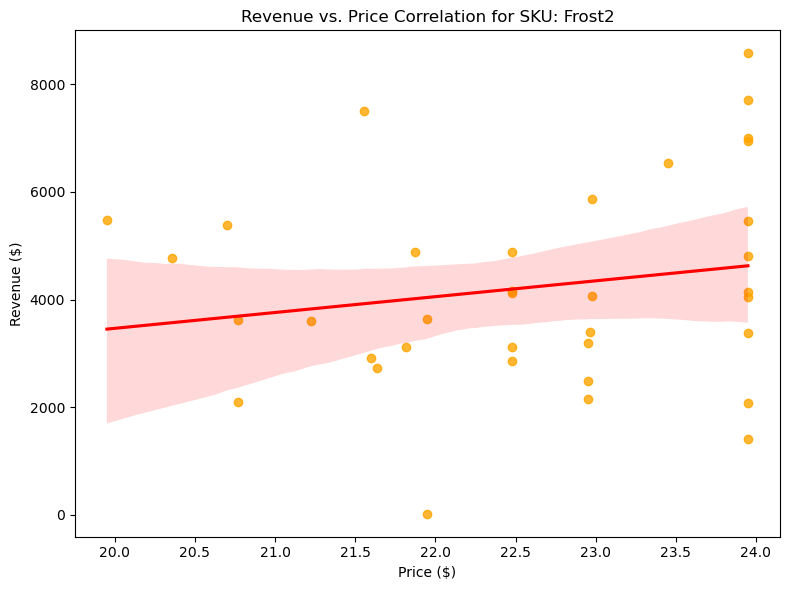

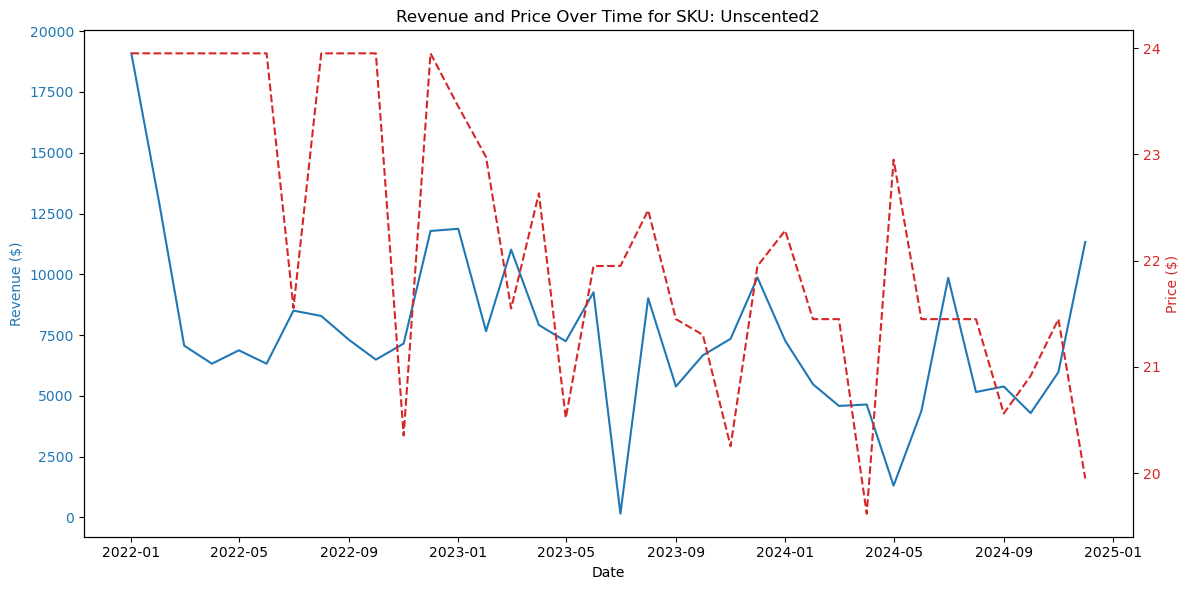

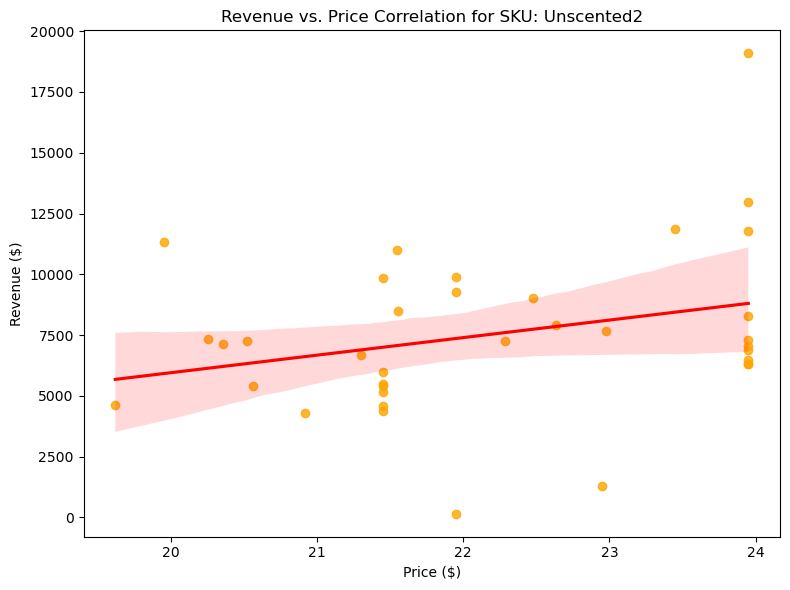

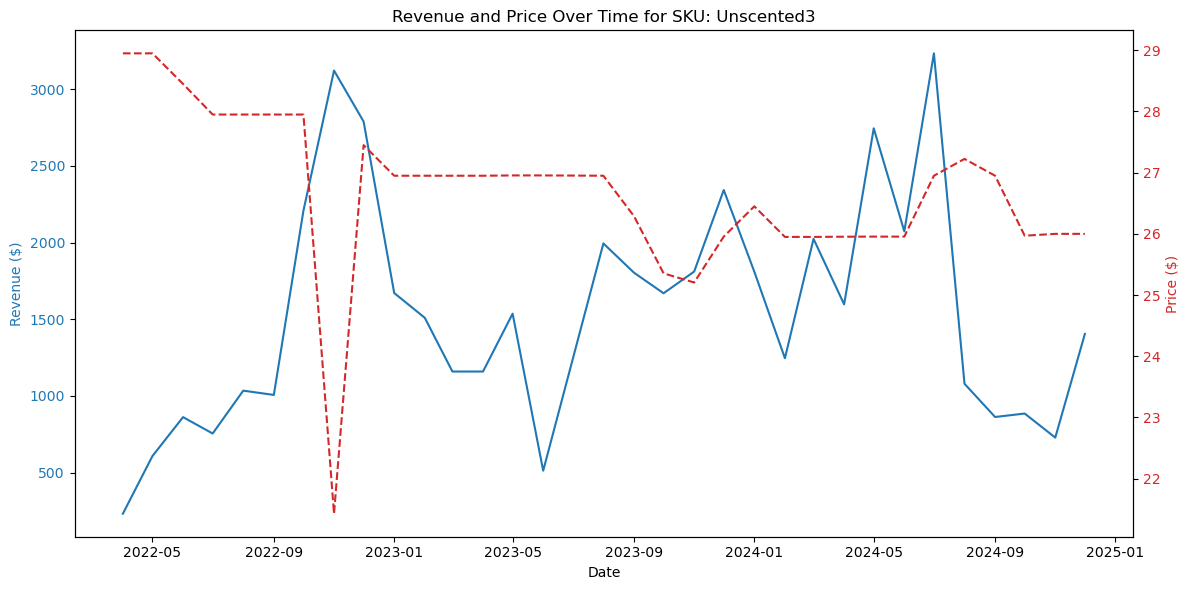

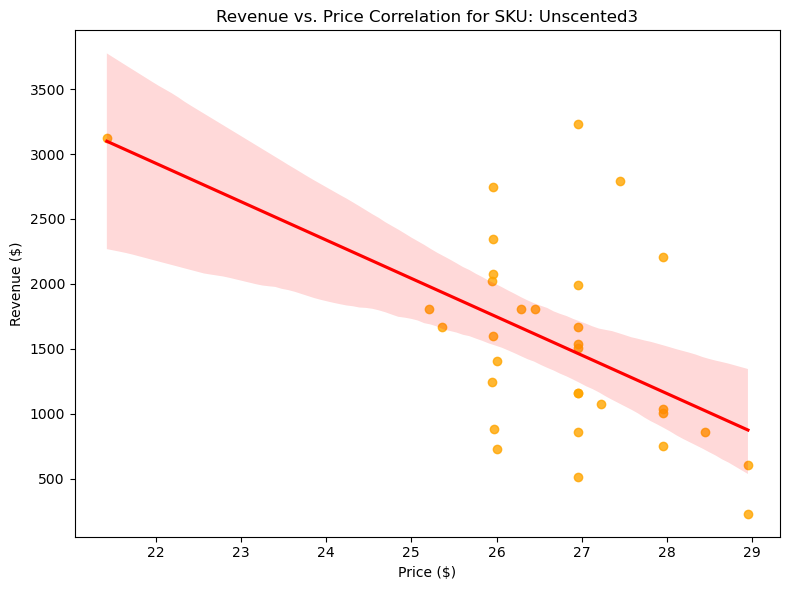

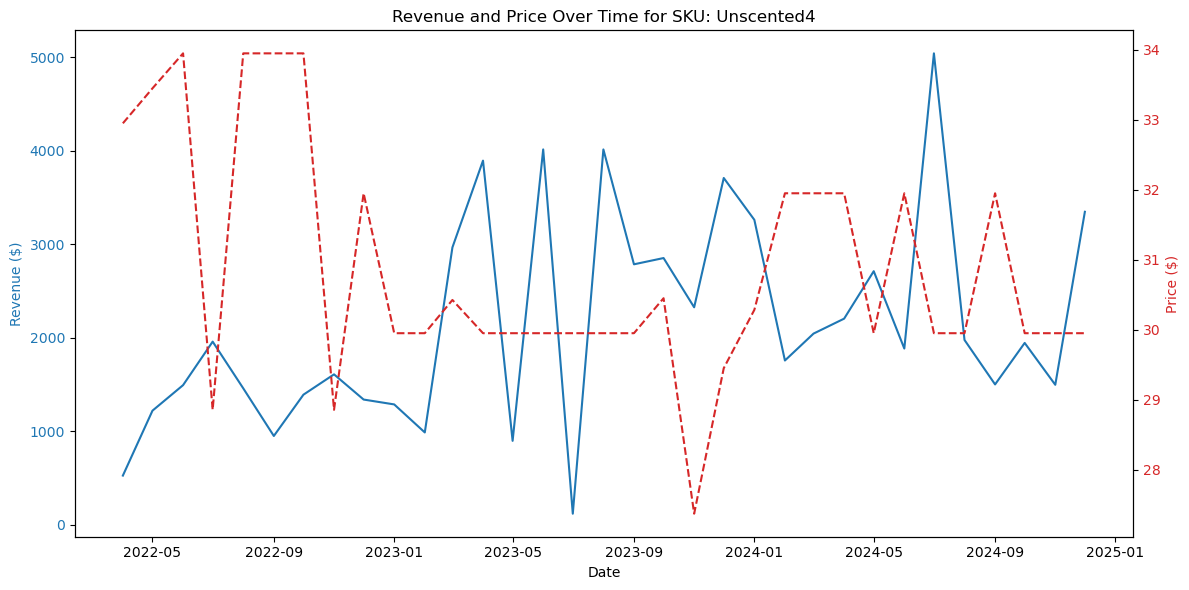

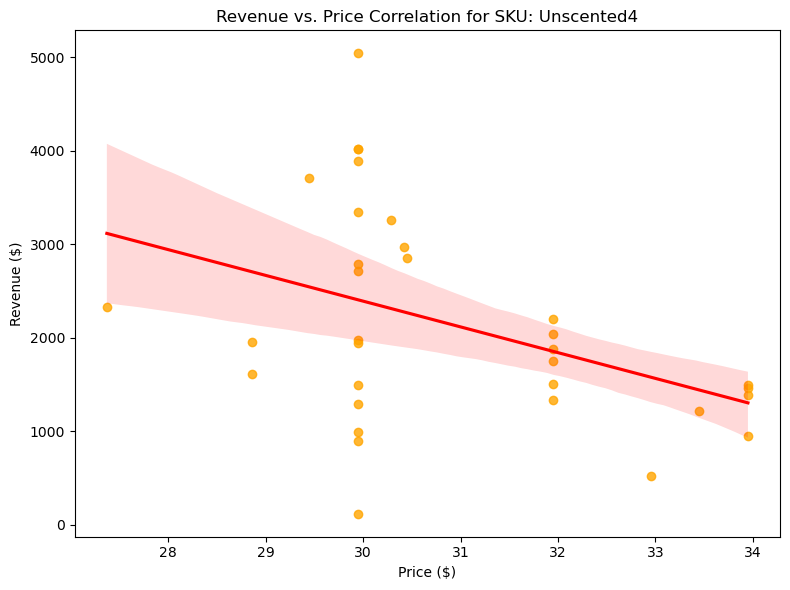

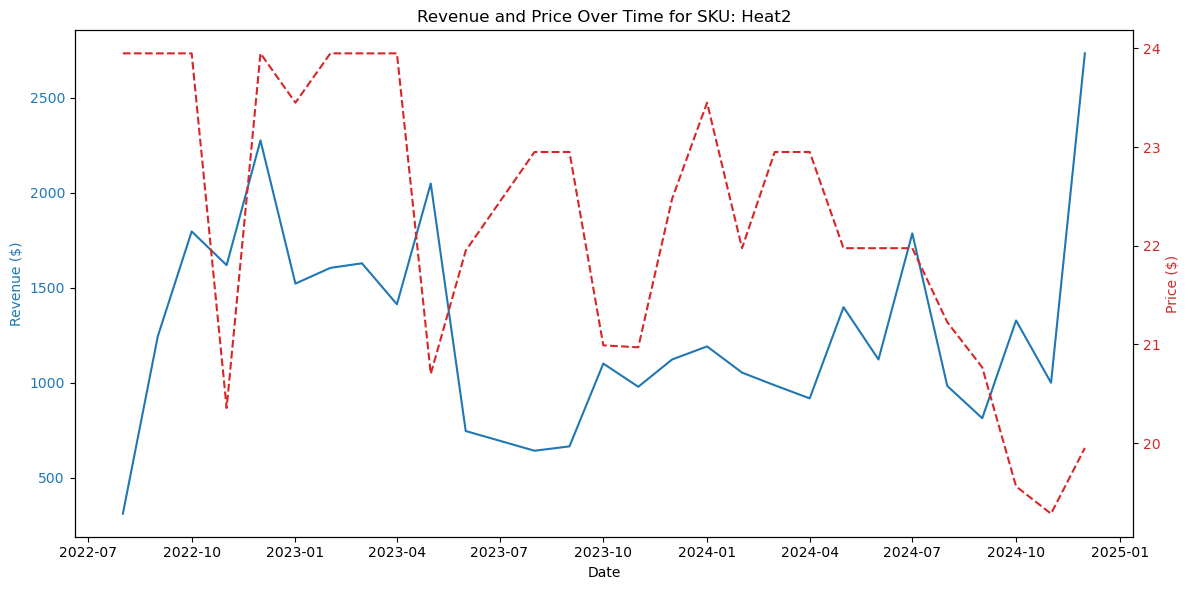

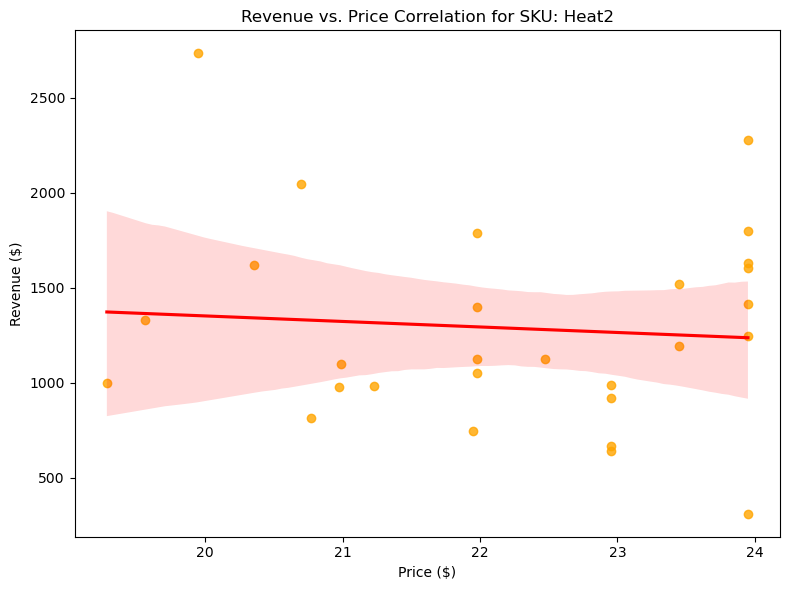

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# First, get a list of all SKUs
sku_list = final_monthly_df['sku'].unique()

# Loop through each SKU
for sku in sku_list:
    # Filter data to the current SKU
    sku_monthly = final_monthly_df[final_monthly_df["sku"] == sku].copy()

    # Aggregate monthly data by year_month
    sku_monthly = sku_monthly.groupby("year_month").agg({
        "total_revenue": "sum",
        "unit-price": "mean"
    }).reset_index()

    # Convert year_month from period to timestamp
    sku_monthly["year_month"] = sku_monthly["year_month"].dt.to_timestamp()

    # Sort by date
    sku_monthly = sku_monthly.sort_values("year_month").reset_index(drop=True)

    # Remove January 2025 sales
    sku_monthly = sku_monthly[sku_monthly["year_month"] < "2025-01-01"].copy()

    # ---- Graph 1: Revenue and Price Over Time ---- #
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Revenue ($)', color='tab:blue')
    ax1.plot(sku_monthly['year_month'], sku_monthly['total_revenue'], color='tab:blue', label='Revenue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Price ($)', color='tab:red')
    ax2.plot(sku_monthly['year_month'], sku_monthly['unit-price'], color='tab:red', label='Price', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(f'Revenue and Price Over Time for SKU: {sku}')
    fig.tight_layout()
    plt.show()

    # ---- Graph 2: Scatterplot Revenue vs. Price ---- #
    plt.figure(figsize=(8, 6))
    sns.regplot(data=sku_monthly, x='unit-price', y='total_revenue', scatter_kws={'color': 'orange'}, line_kws={'color': 'red'})
    plt.xlabel('Price ($)')
    plt.ylabel('Revenue ($)')
    plt.title(f'Revenue vs. Price Correlation for SKU: {sku}')
    plt.tight_layout()
    plt.show()


In [37]:
import pandas as pd

# Start with your final monthly aggregated data
monthly_df = final_monthly_df.copy()

# Aggregate data clearly by SKU and unit-price
sku_price_summary = monthly_df.groupby(['sku', 'unit-price']).agg(
    months_sold=('year_month', 'nunique'),
    total_quantity_sold=('quantity_sold', 'sum'),
    total_revenue=('total_revenue', 'sum'),
    avg_monthly_revenue=('total_revenue', 'mean'),
    revenue_std_dev=('total_revenue', 'std')
).reset_index()

print(sku_price_summary.head())


      sku  unit-price  months_sold  total_quantity_sold  total_revenue  \
0  Frost2       16.76            1                   90        1508.40   
1  Frost2       17.95            1                    8         143.60   
2  Frost2       17.96            1                   63        1131.48   
3  Frost2       18.36            1                   18         330.48   
4  Frost2       18.95            1                   17         322.15   

   avg_monthly_revenue  revenue_std_dev  
0              1508.40              NaN  
1               143.60              NaN  
2              1131.48              NaN  
3               330.48              NaN  
4               322.15              NaN  


In [38]:
# Keep only price points with at least 3 months sold and quantity >= 50 units (adjust as needed)
filtered_summary = sku_price_summary[
    (sku_price_summary['months_sold'] >= 3) &
    (sku_price_summary['total_quantity_sold'] >= 50)
].copy()

print(filtered_summary)

           sku  unit-price  months_sold  total_quantity_sold  total_revenue  \
10      Frost2       21.95            3                  352        7726.40   
12      Frost2       22.95           15                 1586       36398.70   
13      Frost2       23.95           21                 3837       91896.15   
26       Heat2       22.95           15                  525       12048.75   
27       Heat2       23.95           14                  660       15807.00   
39  Unscented2       19.95           15                  863       17216.85   
40  Unscented2       21.95            4                  659       14465.05   
42  Unscented2       22.95           15                 2685       61620.75   
43  Unscented2       23.95           21                 6901      165278.95   
49  Unscented3       25.95            4                  192        4982.40   
50  Unscented3       26.00            3                  113        2938.00   
51  Unscented3       26.95           20             

In [39]:
# Identify best-performing price points per SKU based on avg monthly revenue
best_prices = filtered_summary.loc[filtered_summary.groupby('sku')['avg_monthly_revenue'].idxmax()]

print("\n🔹 Best Prices per SKU (highest avg monthly revenue):")
print(best_prices[['sku', 'unit-price', 'avg_monthly_revenue', 'total_quantity_sold', 'months_sold']])


🔹 Best Prices per SKU (highest avg monthly revenue):
           sku  unit-price  avg_monthly_revenue  total_quantity_sold  \
13      Frost2       23.95          4376.007143                 3837   
27       Heat2       23.95          1129.071429                  660   
43  Unscented2       23.95          7870.426190                 6901   
51  Unscented3       26.95          1390.620000                 1032   
61  Unscented4       30.95          2313.512500                  299   

    months_sold  
13           21  
27           14  
43           21  
51           20  
61            4  


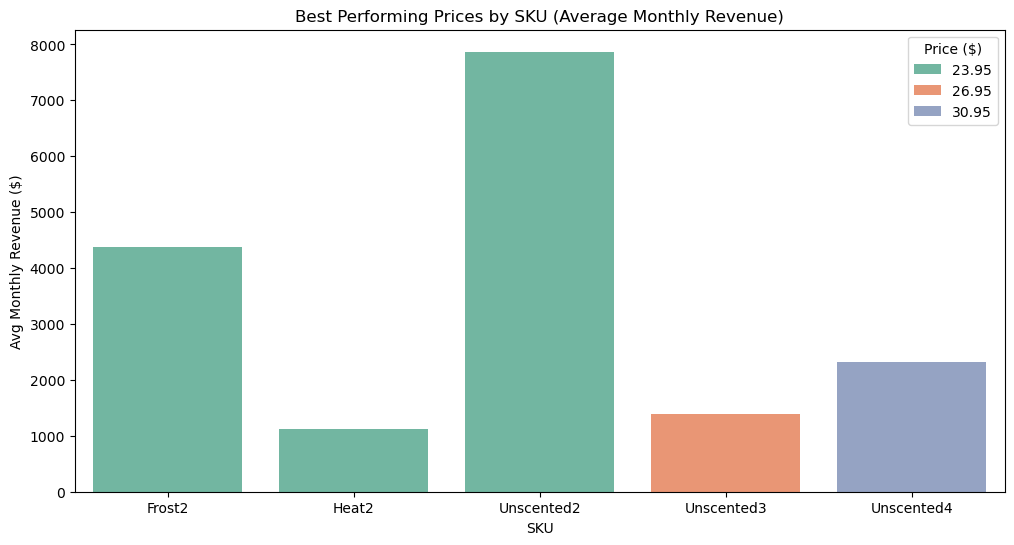

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=best_prices, x='sku', y='avg_monthly_revenue', hue='unit-price', palette='Set2')

plt.title("Best Performing Prices by SKU (Average Monthly Revenue)")
plt.ylabel("Avg Monthly Revenue ($)")
plt.xlabel("SKU")
plt.legend(title='Price ($)')
plt.show()


In [41]:
!pip install prophet

15:27:22 - cmdstanpy - INFO - Chain [1] start processing



📌 Analyzing SKU: Frost2


15:27:23 - cmdstanpy - INFO - Chain [1] done processing


Optimal price for SKU 'Frost2': $19.95 (Expected revenue: $5312.12)
Estimated Price Elasticity: 2.75


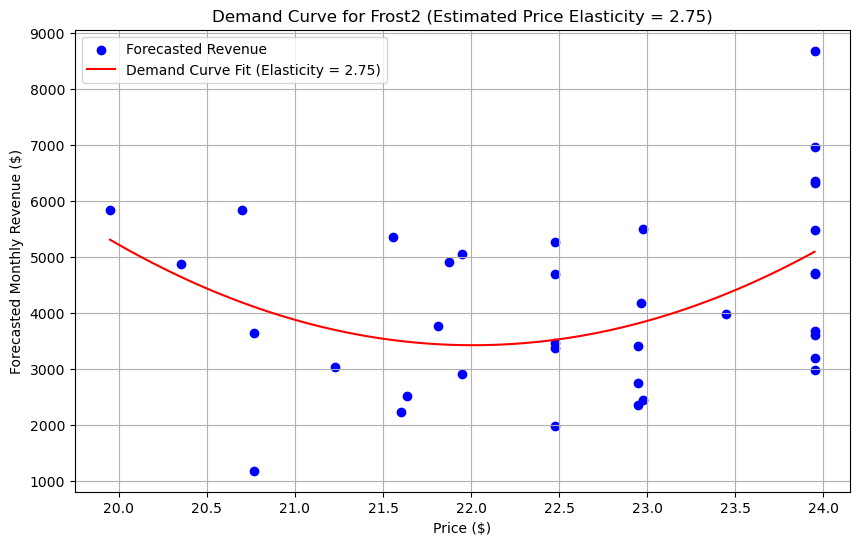

15:27:23 - cmdstanpy - INFO - Chain [1] start processing



📌 Analyzing SKU: Unscented2


15:27:23 - cmdstanpy - INFO - Chain [1] done processing


Optimal price for SKU 'Unscented2': $23.95 (Expected revenue: $9310.93)
Estimated Price Elasticity: 2.20


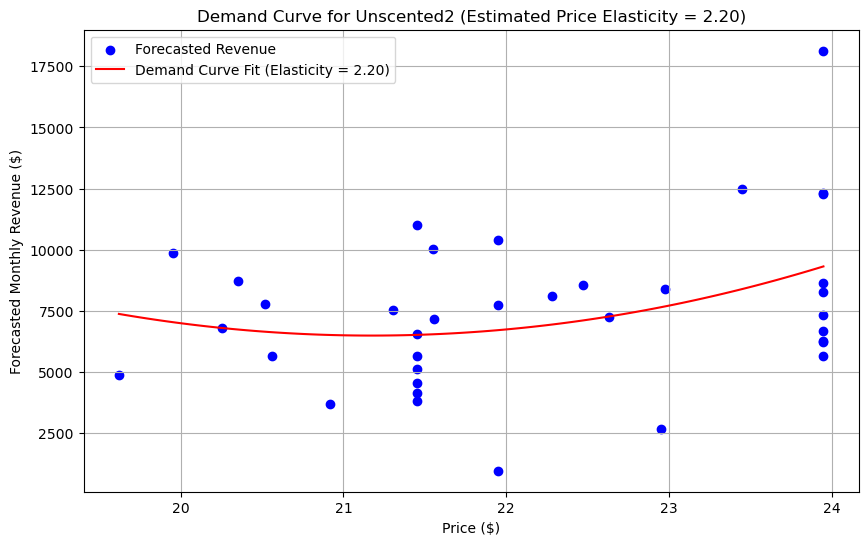


📌 Analyzing SKU: Unscented3


15:27:24 - cmdstanpy - INFO - Chain [1] start processing
15:27:24 - cmdstanpy - INFO - Chain [1] done processing


Optimal price for SKU 'Unscented3': $25.62 (Expected revenue: $1743.17)
Estimated Price Elasticity: -4.41


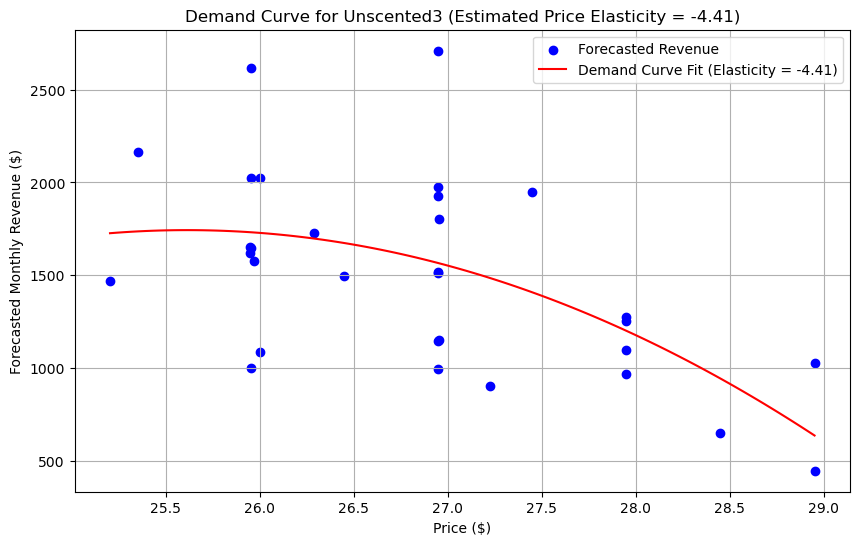


📌 Analyzing SKU: Unscented4


15:27:24 - cmdstanpy - INFO - Chain [1] start processing
15:27:24 - cmdstanpy - INFO - Chain [1] done processing


Optimal price for SKU 'Unscented4': $29.90 (Expected revenue: $2507.60)
Estimated Price Elasticity: -2.76


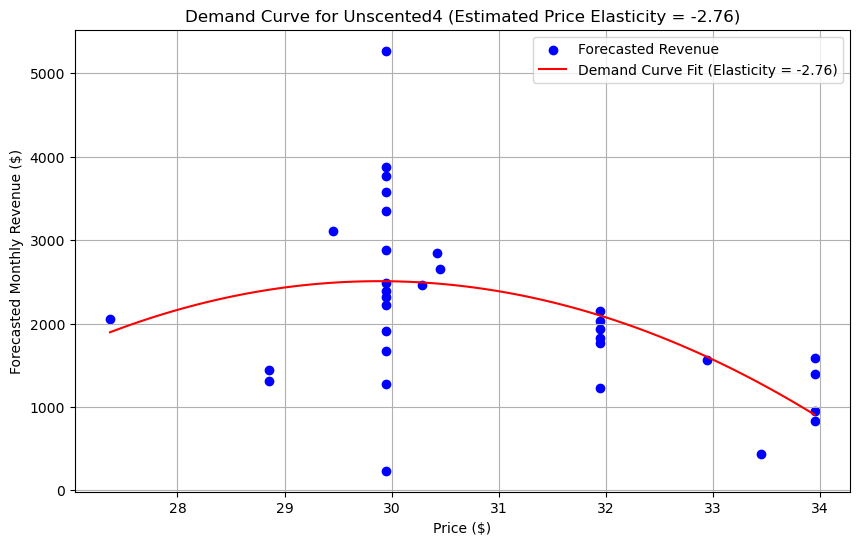


📌 Analyzing SKU: Heat2


15:27:24 - cmdstanpy - INFO - Chain [1] start processing
15:27:25 - cmdstanpy - INFO - Chain [1] done processing


Optimal price for SKU 'Heat2': $19.28 (Expected revenue: $1735.44)
Estimated Price Elasticity: 0.25


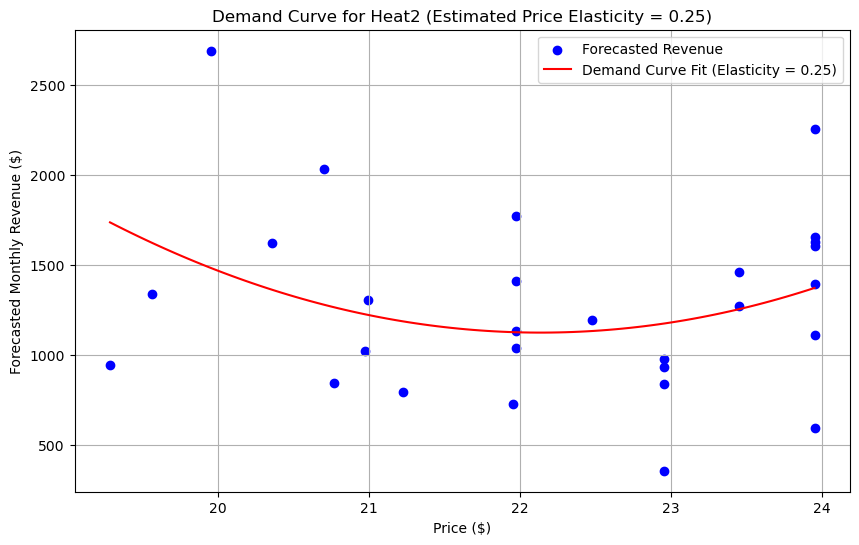


✅ Analysis complete for all SKUs.


In [48]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# List of unique SKUs
sku_list = final_monthly_df["sku"].unique()

# Store results in a dictionary for later use
sku_results = {}

for sku in sku_list:
    print(f"\n📌 Analyzing SKU: {sku}")

    # Filter your data for the selected SKU
    sku_df = final_monthly_df[final_monthly_df["sku"] == sku].copy()

    # Aggregate monthly revenue and price, and sum quantity sold
    sku_monthly = sku_df.groupby("year_month").agg({
        "total_revenue": "sum",
        "unit-price": "mean",
        "quantity_sold": "sum"
    }).reset_index().rename(columns={
        'year_month': 'ds',
        'total_revenue': 'y',
        'unit-price': 'price'
    })

    # Convert ds to datetime (month-start timestamps)
    sku_monthly['ds'] = sku_monthly['ds'].dt.to_timestamp()

    # Keep only data within 2022-01-01 to 2025-01-01
    sku_monthly = sku_monthly[
        (sku_monthly['ds'] >= '2022-01-01') & 
        (sku_monthly['ds'] < '2025-01-01')
    ].copy()

    # For Unscented3, filter out November 2022
    if sku == "Unscented3":
        sku_monthly = sku_monthly[
            ~((sku_monthly['ds'] >= '2022-11-01') & (sku_monthly['ds'] < '2022-12-01'))
        ].copy()

    # Skip this SKU if there are fewer than 6 data points
    if sku_monthly.shape[0] < 6:
        print(f"SKU '{sku}' skipped: not enough data points for modeling.")
        continue

    # --- Prophet Forecast (Step 1) ---
    m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
    m.add_regressor('price')
    m.fit(sku_monthly[['ds', 'y', 'price']])
    future = sku_monthly[['ds', 'price']]
    forecast = m.predict(future)

    # --- Polynomial Regression on Scaled Data (Step 2) ---
    # Use the original price and forecasted revenue (yhat from Prophet)
    prices = sku_monthly['price'].values
    forecasted_revenue = forecast['yhat'].values

    # Scale the price: center and standardize
    mean_price = np.mean(prices)
    std_price = np.std(prices)
    prices_scaled = (prices - mean_price) / std_price

    # Choose the polynomial degree (degree = 2 here)
    degree = 2
    coefs_scaled = np.polyfit(prices_scaled, forecasted_revenue, degree)
    poly_fit_scaled = np.poly1d(coefs_scaled)

    # Generate a range in the scaled domain
    price_range_scaled = np.linspace(prices_scaled.min(), prices_scaled.max(), 100)
    fitted_revenue_scaled = poly_fit_scaled(price_range_scaled)

    # Find the optimal price in the scaled domain (maximizes revenue)
    optimal_index = np.argmax(fitted_revenue_scaled)
    optimal_price_scaled = price_range_scaled[optimal_index]

    # Convert optimal price back to original scale
    optimal_price = optimal_price_scaled * std_price + mean_price
    optimal_rev = np.polyval(coefs_scaled, optimal_price_scaled)

    # Calculate derivative (elasticity) in scaled domain at mean (0) and convert back
    poly_deriv_scaled = np.polyder(poly_fit_scaled)
    elasticity_scaled = poly_deriv_scaled(0)  # at scaled mean (0)
    elasticity_original = elasticity_scaled / std_price

    # Calculate price elasticity (using elasticity = (price/revenue) * derivative)
    price_elasticity = (mean_price / np.mean(forecasted_revenue)) * elasticity_original

    print(f"Optimal price for SKU '{sku}': ${optimal_price:.2f} (Expected revenue: ${optimal_rev:.2f})")
    print(f"Estimated Price Elasticity: {price_elasticity:.2f}")

    # --- Demand Curve Visualization (Step 3) ---
    # Convert the scaled price range back to original price scale for plotting
    price_range_original = price_range_scaled * std_price + mean_price
    fitted_revenue_original = np.polyval(coefs_scaled, price_range_scaled)
    
    plt.figure(figsize=(10,6))
    plt.scatter(prices, forecasted_revenue, color='blue', label='Forecasted Revenue')
    plt.plot(price_range_original, fitted_revenue_original, color='red', 
             label=f'Demand Curve Fit (Elasticity = {price_elasticity:.2f})')
    plt.xlabel("Price ($)")
    plt.ylabel("Forecasted Monthly Revenue ($)")
    plt.title(f"Demand Curve for {sku} (Estimated Price Elasticity = {price_elasticity:.2f})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Store results for the current SKU
    sku_results[sku] = {
        "prophet_model": m,
        "elasticity": price_elasticity,
        "poly_coefficients": coefs_scaled,
        "optimal_price": optimal_price,
        "optimal_revenue": optimal_rev
    }

print("\n✅ Analysis complete for all SKUs.")


In [49]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

sku_to_analyze = 'Unscented3'

# Filter your data for the selected SKU
sku_df = final_monthly_df[final_monthly_df['sku'] == sku_to_analyze].copy()

# Convert to Prophet format (ds, y)
prophet_df = sku_df.groupby('year_month').agg({
    'total_revenue': 'sum',
    'unit-price': 'mean'  # Average monthly price
}).reset_index().rename(columns={'year_month':'ds', 'total_revenue':'y', 'unit-price':'price'})

# Ensure datetime
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'].astype(str))

print(prophet_df.head())


          ds        y  price
0 2022-04-01   231.60  28.95
1 2022-05-01   607.95  28.95
2 2022-06-01   861.50  28.45
3 2022-07-01   754.65  27.95
4 2022-08-01  1034.15  27.95


15:27:30 - cmdstanpy - INFO - Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing


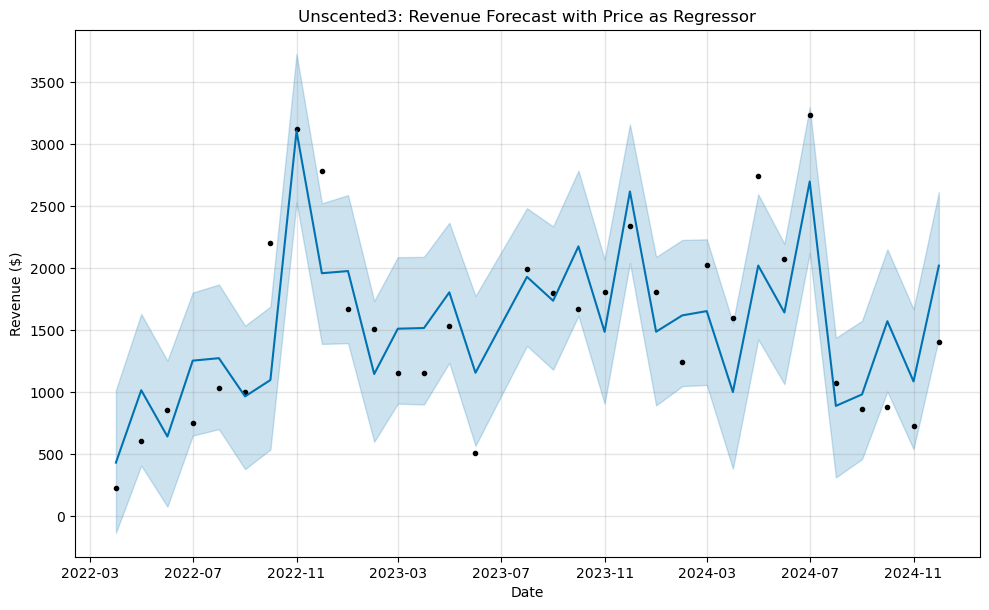

In [50]:
# Include price as a regressor
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
model.add_regressor('price', mode='multiplicative')

# Fit the model
model.fit(prophet_df)

# Create future data frame for predictions (historical price range)
future = prophet_df[['ds', 'price']].copy()

# Predict
forecast = model.predict(future)

# Visualize results
model.plot(forecast)
plt.title(f'{sku_to_analyze}: Revenue Forecast with Price as Regressor')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.show()


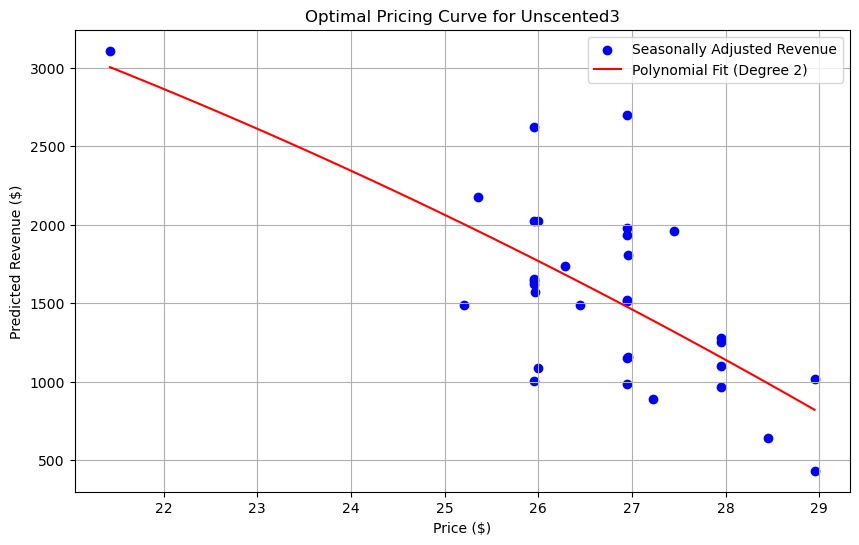

In [51]:
from numpy.polynomial.polynomial import Polynomial

# Extract predicted revenue (trend + seasonality adjusted)
forecasted_revenue = forecast['yhat'].values
prices = prophet_df['price'].values

# Polynomial regression (2nd or 3rd degree is usually sufficient)
degree = 2  # can adjust (2 or 3 usually best)
coeffs = np.polyfit(prices, forecasted_revenue, degree)
poly = np.poly1d(coeffs)

# Generate price range for optimal price
price_range = np.linspace(prices.min(), prices.max(), 100)
predicted_revenue = poly(price_range)

# Plot polynomial fit clearly
plt.figure(figsize=(10,6))
plt.scatter(prices, forecasted_revenue, color='blue', label='Seasonally Adjusted Revenue')
plt.plot(price_range, predicted_revenue, color='red', label=f'Polynomial Fit (Degree {degree})')
plt.xlabel('Price ($)')
plt.ylabel('Predicted Revenue ($)')
plt.title(f'Optimal Pricing Curve for {sku_to_analyze}')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
# Find price corresponding to maximum revenue
optimal_index = np.argmax(predicted_revenue)
optimal_price = price_range[optimal_index]
optimal_rev = predicted_revenue[optimal_index]

print(f"Optimal price for SKU '{sku_to_analyze}': ${optimal_price:.2f} (Expected revenue: ${optimal_rev:.2f})")


Optimal price for SKU 'Unscented3': $21.43 (Expected revenue: $3002.88)


In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# List of unique SKUs from your aggregated monthly DataFrame
sku_list = final_monthly_df["sku"].unique()

# Dictionary to store model results per SKU
sku_models = {}

degree = 2  # Polynomial degree (quadratic)

for sku in sku_list:
    print(f"\n--- Analyzing SKU: {sku} ---")
    
    # Filter data for the current SKU
    sku_df = final_monthly_df[final_monthly_df["sku"] == sku].copy()
    
    # If final_monthly_df doesn't have a "price" column but has "unit-price", rename it
    if "price" not in sku_df.columns and "unit-price" in sku_df.columns:
        sku_df = sku_df.rename(columns={"unit-price": "price"})
    
    # Verify that a "price" column exists
    if "price" not in sku_df.columns:
        print(f"SKU '{sku}' does not have a 'price' column. Skipping...")
        continue
    
    # Ensure that the price and revenue columns are numeric
    sku_df["price"] = pd.to_numeric(sku_df["price"], errors="coerce")
    sku_df["total_revenue"] = pd.to_numeric(sku_df["total_revenue"], errors="coerce")
    
    # Aggregate monthly revenue and price by grouping on "year_month"
    sku_monthly = sku_df.groupby("year_month").agg({
        "total_revenue": "sum",
        "price": "mean",
        "quantity_sold": "sum"
    }).reset_index().rename(columns={
        'year_month': 'ds', 
        'total_revenue': 'y'
    })
    
    # Convert ds from Period to timestamp if needed
    if sku_monthly['ds'].dtype.name.startswith('period'):
        sku_monthly['ds'] = sku_monthly['ds'].dt.to_timestamp()
    else:
        sku_monthly['ds'] = pd.to_datetime(sku_monthly['ds'], errors='coerce')
    
    # Filter out data outside the desired date range (2022-01-01 to 2025-01-01)
    sku_monthly = sku_monthly[
        (sku_monthly['ds'] >= '2022-01-01') & (sku_monthly['ds'] < '2025-01-01')
    ].copy()
    
    # If this is Unscented3, filter out November 2022
    if sku == "Unscented3":
        sku_monthly = sku_monthly[
            ~((sku_monthly['ds'] >= '2022-11-01') & (sku_monthly['ds'] < '2022-12-01'))
        ].copy()
    
    # Check if there are enough data points for modeling
    if sku_monthly.shape[0] < 6:
        print(f"SKU '{sku}' skipped: not enough data points for modeling.")
        continue

    # Extract price and revenue arrays from the monthly data
    prices = sku_monthly["price"].values
    revenue = sku_monthly["y"].values

    # Remove any NaN values
    valid_idx = ~np.isnan(prices) & ~np.isnan(revenue)
    prices = prices[valid_idx]
    revenue = revenue[valid_idx]
    
    if len(prices) < 3:
        print(f"SKU '{sku}' skipped: not enough valid price-revenue pairs for regression.")
        continue

    # --- Scaling the Price Variable ---
    mean_price = np.mean(prices)
    std_price = np.std(prices)
    prices_scaled = (prices - mean_price) / std_price

    # --- Polynomial Regression on Scaled Data ---
    # Create polynomial features from the scaled prices
    X_scaled = np.column_stack([prices_scaled**i for i in range(degree + 1)])
    
    # Fit OLS model using the scaled features
    model = sm.OLS(revenue, X_scaled).fit()
    
    # Print the regression summary for the current SKU
    print(model.summary())
    
    # Store the model in the dictionary
    sku_models[sku] = model

print("\n✅ Analysis complete for all SKUs.")



--- Analyzing SKU: Frost2 ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.660
Date:                Sun, 30 Mar 2025   Prob (F-statistic):             0.0849
Time:                        15:14:27   Log-Likelihood:                -319.44
No. Observations:                  36   AIC:                             644.9
Df Residuals:                      33   BIC:                             649.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3611.2861